In [ ]:
import logging
import time

import btk
import galsim
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scarlet
import scarlet.psf
import seaborn as sns
import sep
import tensorflow as tf
import tensorflow_probability as tfp

from maddeb.Deblender import Deblend
from maddeb.extraction import extract_cutouts
from maddeb.metrics import (
    compute_apperture_photomery,
    compute_pixel_covariance_and_flux,
)

from maddeb.utils import CustomSampling

2022-09-08 15:40:25.504701: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-09-08 15:40:25.504766: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 100.2
max_number = 80
batch_size = 1
maxshift = 44
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed=3

galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = CustomSampling(
    index_range=[60000, 80000], max_number=max_number, maxshift=maxshift, stamp_size=stamp_size, seed=seed
)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [ ]:
blend = next(draw_generator)

Generating blends for LSST survey:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
field_images = blend["blend_images"]
isolated_images = blend["isolated_images"]

# Deblend with Scarlet

In [ ]:
np.shape(field_images)

(1, 6, 501, 501)

In [ ]:
psf = np.array([p.drawImage(galsim.Image(field_images[0].shape[1],field_images[0].shape[2]),scale=survey.pixel_scale.to_value("arcsec")).array for p in blend["psf"]])
bands=[f for f in survey._filters]
wcs = blend["wcs"]

In [ ]:
import scarlet.psf
from scarlet.psf import ImagePSF

In [ ]:
def predict_with_scarlet(image, x_pos, y_pos, show_scene, show_sources, filters):
    sig = []
    weights = np.ones_like(image)
    for i in range(6):
        sig.append(sep.Background(image[i]).globalrms)
        weights[i] = weights[i] / (sig[i]**2)
    observation = scarlet.Observation(
            image, psf=scarlet.psf.ImagePSF(psf), weights= weights, channels=bands, wcs=wcs
        )
    
    model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(filters))
    model_frame = scarlet.Frame(
    image.shape,
    psf=model_psf,
    channels=filters, wcs=wcs)

    
    observation = observation.match(model_frame)
    sources = []
    for i in range(len(x_pos)):
        result = scarlet.ExtendedSource(
            model_frame,
            model_frame.get_sky_coord((x_pos[i], y_pos[i])),
            observation,
            thresh=1,
            shifting=True,
        )
        sources.append(result)

    scarlet.initialization.set_spectra_to_match(sources, observation)
    
    scarlet_blend = scarlet.Blend(sources, observation)
    
    %time it, logL = scarlet_blend.fit(200, e_rel=1e-5)
    #print(f"scarlet ran for {it} iterations to logL = {logL}")
    #scarlet.display.show_likelihood(scarlet_blend)
    #plt.show()
    
    if show_scene:
        scarlet.display.show_scene(sources,
                           norm=None,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
        
        plt.show()
    
    if show_sources:
        scarlet.display.show_sources(sources,
                                 norm=None,
                                 observation=observation,
                                 show_rendered=True,
                                 show_observed=True,
                                 add_boxes=True
                                )
        plt.show()
    
    predicted_sources = []
    for src in sources:
        predicted_sources.append(observation.render(src.get_model(frame=model_frame)))
    #print(np.shape(src.get_model(frame=model_frame)))
    return predicted_sources

In [ ]:
image = field_images[0]

In [ ]:
x_pos = blend['blend_list'][0]['y_peak']
y_pos = blend['blend_list'][0]['x_peak']

In [ ]:
#model = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=True, show_sources=True, filters=bands)

In [ ]:
#plt.imshow(model[0][2])

In [ ]:
scarlet_predictions=[]
for i, image in enumerate(field_images):
    image = field_images[i]
    x_pos = blend['blend_list'][i]['y_peak']
    y_pos = blend['blend_list'][i]['x_peak']
    predicted_sources = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=False, show_sources=False, filters=bands)
    scarlet_predictions.append(predicted_sources)

Zero or negative spectrum [ 7.4461533e+03  5.9583488e+04  9.6527852e+04  7.4653430e+04
  4.0954598e+04 -3.6117252e+01] at [0.01029306 0.00174904]
Completed 7 iterations and [6, 36, 0, 6, 60, 0, 6, 60, 0, 6, 45, 0, 6, 53, 0, 6, 60, 0, 6, 56, 0, 6, 56, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0, 6, 46, 0, 6, 60, 0, 6, 60, 0, 6, 53, 0, 6, 56, 0, 6, 54, 0, 6, 37, 0, 6, 52, 0, 6, 49, 0, 6, 46, 0, 6, 60, 0, 6, 52, 0, 6, 58, 0, 6, 60, 0, 6, 56, 0, 6, 60, 0, 6, 58, 0, 6, 60, 0, 6, 60, 0, 6, 36, 0, 6, 60, 0, 6, 37, 0, 6, 60, 0, 6, 44, 0, 6, 60, 0, 6, 55, 0, 6, 48, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0, 6, 54, 0, 6, 39, 0, 6, 57, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0, 6, 52, 0, 6, 44, 0, 6, 60, 0, 6, 51, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0, 6, 46, 0, 6, 60, 0, 6, 59, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0, 6, 60, 0] sub-iterations
scarlet ran for 46 iterations to logL = -10466831.411764499


CPU times: user 2min 1s, sys: 59.5 s, total: 3min
Wall time: 3min


# Deblend with MADNESS

In [ ]:
from maddeb.Deblender import Deblend
import tensorflow as tf
import tensorflow_probability as tfp


madness_predictions = []
for i in range(len(blend['blend_list'])):

    current_field_predictions = []
    blends = blend['blend_list'][i]
    #print(blends)
    detected_positions = []
    for j in range(len(blends)):
        detected_positions.append([blends['y_peak'][j], blends['x_peak'][j]])

    deb = Deblend(field_images[i], 
                  detected_positions,
                  latent_dim=8, 
                  num_components=len(blends), 
                  use_likelihood=True, 
                  linear_norm_coeff=80000,
                  max_iter=300)
    #tf.config.run_functions_eagerly(False)
    convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=.0000001*45*45*len(blends)*3, min_num_steps=50, window_size=20)
    #convergence_criterion = None
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.06, decay_steps=15, decay_rate=0.8, staircase=True)
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler, momentum=0.1)

    deb(convergence_criterion, optimizer=optimizer, use_debvader=True, compute_sig_dynamically=False)
    
    padding_infos = deb.get_padding_infos()
    for component_num in range(deb.num_components):
        prediction = np.pad(deb.components[component_num], padding_infos[component_num])
        prediction = np.transpose(prediction, axes=(2, 0, 1))
        current_field_predictions.append(prediction)
    madness_predictions.append(current_field_predictions)

2022-09-08 15:46:55.380797: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-09-08 15:46:55.380873: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-08 15:46:55.380980: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-09-08 15:46:55.393900: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2499995000 Hz
2022-09-08 15:46:55.394819: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x565070d17a40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-08 15:46:55.394854: I tensorflow/compiler/xla

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow/python/ops/linalg/linear_operator_lower_triangular.py:151: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:334: calling TransformedDistribution.__init__ (from tensorflow_probability.python.distributions.transformed_distribution) with batch_shape is deprecated and will be removed after 2020-06-01.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:334: calling TransformedDistribution.__init__ (from tensorflow_probability.python.distributions.transformed_distribution) with event_shape is deprecated and will be removed after 2020-06-01.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
2022-09-08 15:47:04.160939: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this m

In [ ]:
madness_predictions= np.array(madness_predictions)

In [ ]:
np.shape(madness_predictions)

(1, 65, 6, 501, 501)

In [ ]:
from maddeb.extraction import extract_cutouts
from maddeb.metrics import compute_pixel_covariance_and_flux, compute_pixel_covariance_and_fluxes

In [ ]:
madness_cov = []
madness_actual_flux = []
madness_predicted_flux = []
for blend_number in range(len(field_images)):

    current_galaxies = isolated_images[blend_number]
    madness_res = compute_pixel_covariance_and_fluxes(madness_predictions[blend_number], current_galaxies, field_images[0])

    madness_cov.append(madness_res[0])
    madness_actual_flux.append(madness_res[1])
    madness_predicted_flux.append(madness_res[2])

# Compare: Covariance matrix and flux reconstruction

In [ ]:
scarlet_cov = []
scarlet_actual_flux = []
scarlet_predicted_flux = []

for blend_number in range(len(field_images)):

    current_galaxies = isolated_images[blend_number]
    scarlet_res = compute_pixel_covariance_and_fluxes(scarlet_predictions[blend_number], current_galaxies, field_images[0])

    scarlet_cov.append(scarlet_res[0])
    scarlet_actual_flux.append(scarlet_res[1])
    scarlet_predicted_flux.append(scarlet_res[2])

In [ ]:
scarlet_cov

[array([0.99926311, 0.99703961, 0.99655908, 0.99917239, 0.99834474,
        0.99889976, 0.99960022, 0.9986943 , 0.99995668, 0.98922567,
        0.99989926, 0.99828358, 0.99978049, 0.99766604, 0.9988516 ,
        0.5429895 , 0.99823752, 0.99939954, 0.9997308 , 0.99945071,
        0.99881369, 0.99929851, 0.99988139, 0.9993915 , 0.99963579,
        0.99783023, 0.99920386, 0.99660136, 0.99824188, 0.99868895,
        0.99983098, 0.99851339, 0.99164567, 0.99918757, 0.9975851 ,
        0.99883615, 0.99887741, 0.99757253, 0.9987579 , 0.99771928,
        0.99929273, 0.99928941, 0.99906091, 0.99929468, 0.99954191,
        0.99979063, 0.99860413, 0.99989401, 0.99903996, 0.99973091,
        0.9932278 , 0.99938525, 0.99642772, 0.99876899, 0.99761738,
        0.99576682, 0.99623609, 0.99898533, 0.99817836, 0.99969309,
        0.99768442, 0.97307767, 0.99970329, 0.99994373, 0.99756677])]

(0.95, 1.0)

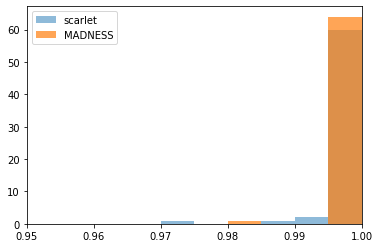

In [ ]:
bins = np.arange(.95, 1, .005)
plt.hist(scarlet_cov, bins=bins, alpha=0.5, label="scarlet");
plt.hist(madness_cov, bins=bins, alpha=0.7, label="MADNESS");
plt.legend()
plt.xlim([.95, 1])

In [ ]:
scarlet_actual_flux = np.array(scarlet_actual_flux)
scarlet_predicted_flux = np.array(scarlet_predicted_flux)

scarlet_relative_difference= np.divide(scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux)

In [ ]:
madness_actual_flux = np.array(madness_actual_flux)
madness_predicted_flux = np.array(madness_predicted_flux)

madness_relative_difference= np.divide(madness_predicted_flux - madness_actual_flux, madness_actual_flux)

In [ ]:
scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))].reshape(-1)

array([ 5.72397160e-03,  4.24337640e-02,  5.08128912e-02,  2.08308118e-02,
        4.24564713e-02,  1.59295740e-01,  8.86422284e-03,  2.28034098e-02,
        3.24991225e-02,  1.77003172e-02,  9.53434374e-02,  2.90867497e-01,
        1.69434407e-02, -1.39159397e-02,  7.79885101e-02,  4.48539257e-03,
        9.42228860e-02,  2.64248341e-01, -5.30319409e-02, -1.23131946e-02,
        2.71635540e-02, -7.65244134e-03,  2.15532372e-02,  5.24085423e-02,
       -5.60802107e-02,  3.92569539e-02, -3.51281174e-02,  1.59364010e-02,
       -7.91854730e-02, -9.73433840e-02,  5.35129348e-02,  3.28786432e-02,
        3.80506138e-02,  6.94537305e-02,  6.43125788e-02,  1.56472598e-01,
        3.38603561e-02,  2.12408519e-02,  6.03420506e-03,  3.07909768e-02,
        2.03614378e-02, -1.79314115e-02, -2.91452957e-02,  5.00133105e-02,
        1.94866064e-02,  3.90733201e-03, -5.63218673e-03, -1.32401777e-01,
       -9.75095091e-03, -7.68257200e-03, -6.68627750e-03, -1.21454061e-02,
       -6.63256038e-03,  

In [ ]:
np.array_equal(madness_actual_flux, scarlet_actual_flux)

True

In [ ]:
from scipy.optimize import curve_fit
def gauss(x, sig, mu):
    return 1/np.sqrt(2.*np.pi)/sig*np.exp(-0.5*(x-mu)**2/sig**2)

n_bins=100
hist, bin_tmp = np.histogram(madness_relative_difference, n_bins, density=True)
bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
madness_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins)])

hist, bin_tmp = np.histogram(scarlet_relative_difference, n_bins, density=True)
bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
scarlet_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins)])

In [ ]:
madness_fit

(array([ 0.02190079, -0.0080039 ]),
 array([[1.06278322e-06, 3.53884623e-10],
        [3.53884623e-10, 1.59329833e-06]]))

In [ ]:
bins

array([-0.77370653, -0.73906265, -0.70441876, -0.66977487, -0.63513099,
       -0.6004871 , -0.56584321, -0.53119933, -0.49655544, -0.46191156,
       -0.42726767, -0.39262378, -0.3579799 , -0.32333601, -0.28869213,
       -0.25404824, -0.21940435, -0.18476047, -0.15011658, -0.1154727 ,
       -0.08082881, -0.04618492, -0.01154104,  0.02310285,  0.05774673,
        0.09239062,  0.12703451,  0.16167839,  0.19632228,  0.23096616,
        0.26561005,  0.30025394,  0.33489782,  0.36954171,  0.4041856 ,
        0.43882948,  0.47347337,  0.50811725,  0.54276114,  0.57740503,
        0.61204891,  0.6466928 ,  0.68133668,  0.71598057,  0.75062446,
        0.78526834,  0.81991223,  0.85455611,  0.8892    ,  0.92384389,
        0.95848777,  0.99313166,  1.02777554,  1.06241943,  1.09706332,
        1.1317072 ,  1.16635109,  1.20099498,  1.23563886,  1.27028275,
        1.30492663,  1.33957052,  1.37421441,  1.40885829,  1.44350218,
        1.47814606,  1.51278995,  1.54743384,  1.58207772,  1.61

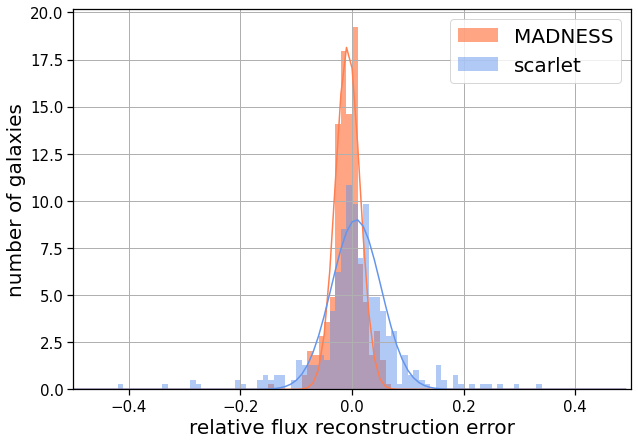

In [ ]:
import seaborn as sns
from scipy.stats import norm
#print(madness_relative_difference[np.logical_not(np.isinf(madness_relative_difference))].reshape(-1))
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'black',
                     'figure.facecolor': '1',
                     'xtick.color': 'black',
                     'ytick.color': 'black',
                     'text.color': 'black',
                     'image.cmap': 'viridis',})
plt.figure(figsize=(10,7))
bins = np.arange(-.5,.5, .01)
plt.hist(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))].reshape(-1), bins=bins, density=True, alpha=0.7, color="coral", label="MADNESS");
plt.plot(bins, norm.pdf(bins, madness_fit[0][1], madness_fit[0][0]), color="coral")
plt.hist(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))].reshape(-1), bins=bins, density=True, alpha=0.5, color="cornflowerblue", label="scarlet");
plt.plot(bins, norm.pdf(bins, scarlet_fit[0][1], scarlet_fit[0][0]), color="cornflowerblue")
plt.legend(fontsize=20)
ax=plt.gca()
plt.xlabel("relative flux reconstruction error", fontsize=20)
ax.tick_params(labelsize=15)
plt.ylabel("number of galaxies", fontsize=20)
plt.xlim([-.5,.5])
plt.savefig("flux_err", transparent=True)

In [ ]:
print(np.amax(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))]))
print(np.amin(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))]))

2.6733601337097808
-0.7910284744959054


In [ ]:
print(np.amax(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))]))
print(np.amin(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))]))

0.06019479957578758
-0.14613051542028063


# Compute Apperture photometry

In [ ]:
from maddeb.metrics import compute_apperture_photomery

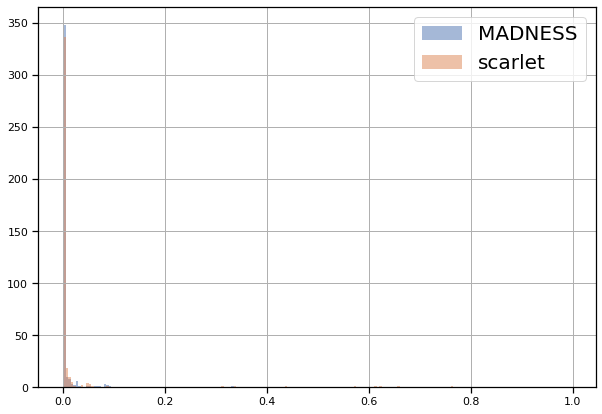

In [ ]:
actual_residual_field = blend["blend_images"][0]
scarlet_residual_field = blend["blend_images"][0]

for i in range(len(scarlet_predictions[0])):
    actual_residual_field = actual_residual_field - blend["isolated_images"][0][i]
    scarlet_residual_field = scarlet_residual_field - scarlet_predictions[0][i]

padding_infos = deb.get_padding_infos()
madness_residual_field = deb.compute_residual(
    blend["blend_images"][0], use_scatter_and_sub=True
).numpy()

bkg_rms = {}
for band in range(6):
    bkg_rms[band] = sep.Background(blend["blend_images"][0][band]).globalrms

actual_gal_fluxes, actual_gal_fluxerrs, actual_gal_flags = compute_apperture_photomery(
    residual_field=actual_residual_field,
    predictions=blend["isolated_images"][0],
    xpos=blend["blend_list"][0]["x_peak"],
    ypos=blend["blend_list"][0]["y_peak"],
    bkg_rms=bkg_rms,
)

(
    madness_gal_fluxes,
    madness_gal_fluxerrs,
    madness_gal_flags,
) = compute_apperture_photomery(
    residual_field=np.transpose(madness_residual_field,  axes=(2, 0, 1)),
    predictions=madness_predictions[0],
    xpos=blend["blend_list"][0]["x_peak"],
    ypos=blend["blend_list"][0]["y_peak"],
    bkg_rms=bkg_rms,
)

(
    scarlet_gal_fluxes,
    scarlet_gal_fluxerrs,
    scarlet_gal_flags,
) = compute_apperture_photomery(
    residual_field=scarlet_residual_field,
    predictions=scarlet_predictions[0],
    xpos=blend["blend_list"][0]["x_peak"],
    ypos=blend["blend_list"][0]["y_peak"],
    bkg_rms=bkg_rms,
)

plt.figure(figsize=(10, 7))
bins = np.arange(0, 1, 0.005)
plt.hist(
    np.abs((madness_gal_fluxes - actual_gal_fluxes) / actual_gal_fluxes),
    bins=bins,
    alpha=0.5,
    label="MADNESS",
)

plt.hist(
    np.abs((scarlet_gal_fluxes - actual_gal_fluxes) / actual_gal_fluxes),
    bins=bins,
    alpha=0.5,
    label="scarlet",
)

plt.legend(fontsize=20)

plt.savefig("aperturephoto")


In [ ]:
np.shape(madness_residual_field)

(501, 501, 6)

In [ ]:
scarlet_gal_fluxes

array([7.66294577e+03, 6.28664936e+04, 1.32282860e+05, 9.89050019e+04,
       6.01471584e+04, 3.20264173e+04, 3.42642278e+03, 2.96161926e+04,
       6.30903244e+04, 4.77127425e+04, 3.04717118e+04, 1.58270881e+04,
       2.98893052e+03, 2.34637174e+04, 5.27156617e+04, 3.88161761e+04,
       2.58681425e+04, 1.06277483e+04, 4.33917983e+03, 3.83137757e+04,
       8.35385996e+04, 6.24293772e+04, 3.84306629e+04, 1.91630669e+04,
       4.13350853e+03, 3.79702694e+04, 7.47469994e+04, 5.74958914e+04,
       3.32081052e+04, 1.47504307e+04, 8.64452364e+03, 6.83623962e+04,
       1.42856218e+05, 1.09889251e+05, 6.98172331e+04, 3.41557455e+04,
       1.07940307e+04, 8.68723885e+04, 1.77808008e+05, 1.38060997e+05,
       8.63991169e+04, 4.12391386e+04, 5.35837477e+03, 4.69812649e+04,
       9.54224435e+04, 7.07057964e+04, 4.34418251e+04, 1.82171511e+04,
       5.57127344e+05, 4.52118301e+06, 9.25017124e+06, 6.95830957e+06,
       4.27120521e+06, 1.99257437e+06, 2.94469878e+03, 2.29689788e+04,
      

In [ ]:
actual_gal_fluxes

array([7.66094623e+03, 6.28506903e+04, 1.32251185e+05, 9.88814279e+04,
       6.01327944e+04, 3.20196138e+04, 3.42376677e+03, 2.95952186e+04,
       6.30491436e+04, 4.76830397e+04, 3.04529965e+04, 1.58174715e+04,
       2.98295628e+03, 2.34185951e+04, 5.26286049e+04, 3.87511167e+04,
       2.58294473e+04, 1.06080860e+04, 4.34046071e+03, 3.83159459e+04,
       8.35374371e+04, 6.24300813e+04, 3.84355836e+04, 1.91632919e+04,
       4.13294527e+03, 3.79656614e+04, 7.47379870e+04, 5.74886028e+04,
       3.32039665e+04, 1.47488951e+04, 8.59233989e+03, 6.79426909e+04,
       1.42035925e+05, 1.09288047e+05, 6.94668724e+04, 3.39999651e+04,
       1.07938584e+04, 8.68710055e+04, 1.77805212e+05, 1.38058892e+05,
       8.63978342e+04, 4.12385326e+04, 5.35756736e+03, 4.69749831e+04,
       9.54100861e+04, 7.06965453e+04, 4.34363231e+04, 1.82145606e+04,
       5.57126308e+05, 4.52117478e+06, 9.25015488e+06, 6.95829762e+06,
       4.27119797e+06, 1.99257081e+06, 2.94383201e+03, 2.29623720e+04,
      

In [ ]:
madness_gal_fluxes

array([7.66426260e+03, 6.28771337e+04, 1.32303998e+05, 9.89215808e+04,
       6.01575828e+04, 3.20313703e+04, 3.43347018e+03, 2.96721288e+04,
       6.31622948e+04, 4.77724750e+04, 3.05052815e+04, 1.58439679e+04,
       2.99275557e+03, 2.34882203e+04, 5.27093337e+04, 3.88014896e+04,
       2.58500184e+04, 1.06439080e+04, 4.34273587e+03, 3.83484397e+04,
       8.35211891e+04, 6.24255761e+04, 3.84238812e+04, 1.91734879e+04,
       4.13439693e+03, 3.79772613e+04, 7.47611695e+04, 5.75064562e+04,
       3.32150872e+04, 1.47542276e+04, 8.60245982e+03, 6.79738861e+04,
       1.42187305e+05, 1.09441601e+05, 6.94716320e+04, 3.41321561e+04,
       1.07946770e+04, 8.68776994e+04, 1.77818927e+05, 1.38069695e+05,
       8.64046880e+04, 4.12418679e+04, 5.36007856e+03, 4.69949904e+04,
       9.54499830e+04, 7.07272288e+04, 4.34554233e+04, 1.82237141e+04,
       5.57130098e+05, 4.52120455e+06, 9.25021283e+06, 6.95834179e+06,
       4.27122518e+06, 1.99258371e+06, 2.94587687e+03, 2.29786608e+04,
      